# AutoEncoder implementation in Lasagne

In [1]:
import gzip
import cPickle
import numpy as np
import theano
import theano.tensor as T
import random

examples_per_labels = 10


# Load the pickle file for the MNIST dataset.
dataset = 'mnist.pkl.gz'

f = gzip.open(dataset, 'rb')
train_set, dev_set, test_set = cPickle.load(f)
f.close()

#train_set contains 2 entries, first the X values, second the Y values
train_x, train_y = train_set
dev_x, dev_y = dev_set
test_x, test_y = test_set

print 'Train: ', train_x.shape
print 'Dev: ', dev_x.shape
print 'Test: ', test_x.shape

examples = []
examples_labels = []
examples_count = {}

for idx in xrange(train_x.shape[0]):
    label = train_y[idx]
    
    if label not in examples_count:
        examples_count[label] = 0
    
    if examples_count[label] < examples_per_labels:
        arr = train_x[idx]
        examples.append(arr)
        examples_labels.append(label)
        examples_count[label]+=1

train_subset_x = np.asarray(examples)
train_subset_y = np.asarray(examples_labels)

print "Train Subset: ",train_subset_x.shape



Couldn't import dot_parser, loading of dot files will not be possible.
Train:  (50000, 784)
Dev:  (10000, 784)
Test:  (10000, 784)
Train Subset:  (100, 784)


# Autoencoder
This is the code how the autoencoder should work in principle. However, the pretraining seems not to work as the loss stays approx. identical for all epochs. If someone finds the problem, please send me an email.

In [16]:
import lasagne

def autoencoder(n_in, n_hidden, input_var=None):
    #Input layer, 1 dimension = number of samples, 2 dimension = input, our 28*28 image
    l_in = lasagne.layers.InputLayer(shape=(None, n_in), input_var=input_var)
    
    
    l_hid0 = lasagne.layers.DenseLayer(incoming=l_in,
                num_units=100, nonlinearity=lasagne.nonlinearities.tanh,
                W=lasagne.init.GlorotUniform())
    
    # Our first hidden layer with n_hidden units
    # As nonlinearity we use tanh, you could also try rectify
    l_hid = lasagne.layers.DenseLayer(incoming=l_hid0,
                num_units=n_hidden, nonlinearity=lasagne.nonlinearities.tanh,
                W=lasagne.init.GlorotUniform())
    
    # Our output layer (a softmax layer)
    l_out = lasagne.layers.DenseLayer(incoming=l_hid, 
            num_units=n_in, nonlinearity=lasagne.nonlinearities.tanh)
    
    return l_hid, l_out


# Parameters
n_in = 28*28
n_hidden = 2



# Create the network
x = T.fmatrix('x')  # the data, one image per row
y = T.lvector('y')  # the labels are presented as 1D vector of [int] labels

ae_hid, ae_out = autoencoder(n_in, n_hidden, x)

prediction = lasagne.layers.get_output(ae_out)
loss = lasagne.objectives.squared_error(prediction, x)
loss = loss.mean()

params = lasagne.layers.get_all_params(ae_out, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.01, momentum=0.9)



train_fn = theano.function(inputs=[x], outputs=loss, updates=updates)

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
        
        
number_of_epochs = 10
print "%d epochs" % number_of_epochs

for epoch in xrange(number_of_epochs):
    
    loss = 0
    for batch in iterate_minibatches(train_x, train_y, 100, shuffle=True):
        inputs, targets = batch
        loss += train_fn(inputs)   
        
    print "%d loss: %f" % (epoch,loss)   

print "Done"


10 epochs
0 loss: 53.243441
1 loss: 47.135972
2 loss: 40.912191
3 loss: 37.145864
4 loss: 35.252917
5 loss: 34.274907
6 loss: 33.715676
7 loss: 33.357017
8 loss: 33.111290
9 loss: 32.933791
Done


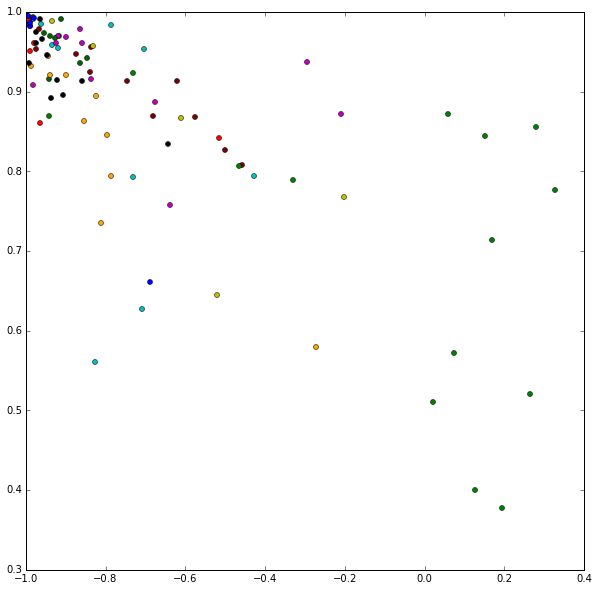

In [17]:
############
# Plot it
############
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

network_predict_label = lasagne.layers.get_output(ae_hid, deterministic=True)
predict_points = theano.function(inputs=[x], outputs=network_predict_label)

train_predict = predict_points(train_x)

colors = {0: 'b', 1: 'g', 2: 'r', 3:'c', 4:'m',
          5:'y', 6:'k', 7:'orange', 8:'darkgreen', 9:'maroon'}


plt.figure(figsize=(10, 10)) 
patches = []
for idx in xrange(0,100):    
    point = train_predict[idx]
    label = train_y[idx]
    color = colors[label]
    
    line = plt.plot(point[0], point[1], color=color, marker='o', markersize=5)
        
